In [2]:
from pymongo import MongoClient

mongo_client = MongoClient()
database = mongo_client["graduation"]
pull_requests_collection = database["pull_requests"]
projects_collection = database["projects"]
commits_collection = database["commits"]

# Introduction

We are interested in determining what the order of CI introduction services is. For this we pre-processed the commit statuses to find all CI services with more than 10 usages per project.

## Circle

First we analyze all projects that have been scraped for the circle dataset. 

In [19]:
from statistics import mean

circle_projects = list(projects_collection.find({'scrape_type': 'icse_1', 'succeeded': True, 'services': {'$exists': True}}))

print("Total of {} projects".format(len(circle_projects)))

no_ci = 0
no_circle = 0
no_travis = 0
circle_older = 0
travis_older = 0

no_travis_prs = []
circle_older_prs = []
travis_older_prs = []

travis_older_gaps = []

for project in circle_projects:
    name = project["full_name"].split("/")[1]
    owner = project["full_name"].split("/")[0]
    
    number_of_prs = pull_requests_collection.count_documents({'project_name': name, 'project_owner': owner, 'created_at': {'$lt': project["status_circle_date"]}})
    
    travis_service = next(iter([service for service in project["services"] if service["host"] == "travis-ci.org"]), None)
    circle_service = next(iter([service for service in project["services"] if service["host"] == "circleci.com"]), None)
    
    if travis_service is None and circle_service is None:
        no_ci += 1
    elif travis_service is None:
        no_travis += 1
        no_travis_prs.append(number_of_prs)
    elif circle_service is None:
        no_circle += 1
    else:
        if travis_service["introduced"] < circle_service["introduced"]:
            travis_older += 1
            travis_older_prs.append(number_of_prs)
            travis_older_gaps.append((circle_service["introduced"] - travis_service["introduced"]).total_seconds())
        else:
            circle_older += 1
            circle_older_prs.append(number_of_prs)
        
print("{} projects with no CI, {} projects with no circle, {} projects with no travis".format(no_ci, no_circle, no_travis))
print("Out of the remaining projects there are {} projects where travis is older and {} where circle is older".format(travis_older, circle_older))

print("Mean delta between travis then circle is {}".format(mean(travis_older_gaps)/(3600*24*30)))

Total of 2844 projects
165 projects with no CI, 71 projects with no circle, 1415 projects with no travis
Out of the remaining projects there are 836 projects where travis is older and 357 where circle is older
Mean delta between travis then circle is 25.60670158963539


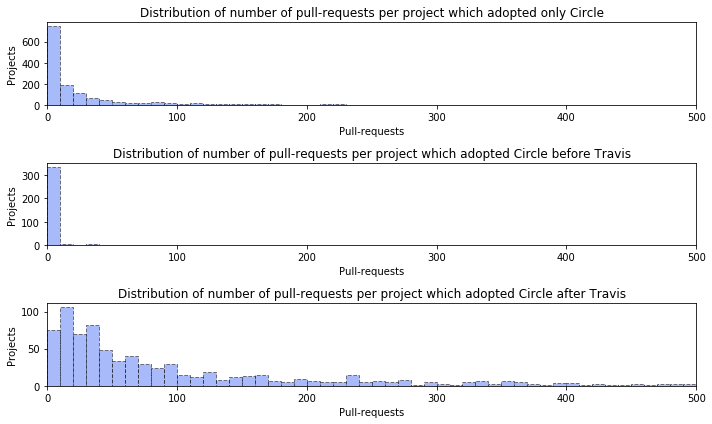

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))

ax = plt.subplot(3, 1, 1)

plt.hist(no_travis_prs, bins = 50, color='#5177f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted only Circle")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 2)

plt.hist(circle_older_prs, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle before Travis")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 3)

plt.hist(travis_older_prs, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle after Travis")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

plt.tight_layout()

plt.show()



# Travis first

In [23]:
from statistics import mean

circle_projects = list(projects_collection.find({'scrape_type': {'$exists': False}, 'succeeded': True, 'services': {'$exists': True}}))

print("Total of {} projects".format(len(circle_projects)))

no_ci = 0
no_circle = 0
no_travis = 0
circle_older = 0
travis_older = 0

no_circle_prs = []
no_travis_prs = []
circle_older_prs = []
travis_older_prs = []

travis_older_gaps = []

for project in circle_projects:
    name = project["full_name"].split("/")[1]
    owner = project["full_name"].split("/")[0]
    
    number_of_prs = pull_requests_collection.count_documents({'project_name': name, 'project_owner': owner, 'created_at': {'$lt': project["status_travis_date"]}})
    
    travis_service = next(iter([service for service in project["services"] if service["host"] == "travis-ci.org"]), None)
    circle_service = next(iter([service for service in project["services"] if service["host"] == "circleci.com"]), None)
    
    if travis_service is None and circle_service is None:
        no_ci += 1
    elif travis_service is None:
        no_travis += 1
        no_travis_prs.append(number_of_prs)
    elif circle_service is None:
        no_circle += 1
        no_circle_prs.append(number_of_prs)
    else:
        if travis_service["introduced"] < circle_service["introduced"]:
            travis_older += 1
            travis_older_prs.append(number_of_prs)
            travis_older_gaps.append((circle_service["introduced"] - travis_service["introduced"]).total_seconds())
        else:
            circle_older += 1
            circle_older_prs.append(number_of_prs)
        
print("{} projects with no CI, {} projects with no circle, {} projects with no travis".format(no_ci, no_circle, no_travis))
print("Out of the remaining projects there are {} projects where travis is older and {} where circle is older".format(travis_older, circle_older))

print("Mean delta between travis then circle is {}".format(mean(travis_older_gaps)/(3600*24*30)))

Total of 755 projects
2 projects with no CI, 673 projects with no circle, 0 projects with no travis
Out of the remaining projects there are 76 projects where travis is older and 4 where circle is older
Mean delta between travis then circle is 36.54225681753574


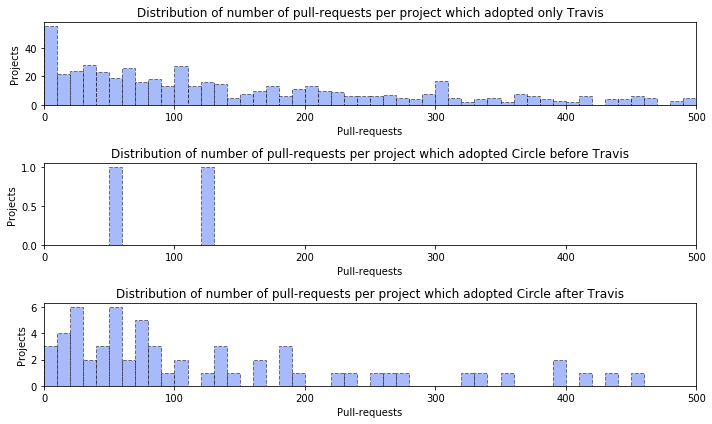

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))

ax = plt.subplot(3, 1, 1)

plt.hist(no_circle_prs, bins = 50, color='#5177f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted only Travis")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 2)

plt.hist(circle_older_prs, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle before Travis")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 3)

plt.hist(travis_older_prs, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle after Travis")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

plt.tight_layout()

plt.show()

